In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
import string
import math

import scipy.stats as sts

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens

import tensorflow as tf
from tensorflow import keras

# from keras import models as kermdls
# from keras import layers as kerlrs
# from keras import metrics as kmetrics

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe

import pickle

import nilearn as nl
from nilearn import plotting, image
from nilearn import datasets
import nibabel as nb
import h5py

import os

import time

Using TensorFlow backend.


In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1713195233200346026
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2423005201898986984
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6589725830
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4696772088027073106
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17139215174213066508
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
data = pd.read_csv('00_Data/train_scores.csv')
data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235


In [6]:
data.isnull().sum()

Id                0
age               0
domain1_var1    438
domain1_var2    438
domain2_var1     39
domain2_var2     39
dtype: int64

In [7]:
data = data.dropna()

In [8]:
# fnc_10 = pd.read_csv('00_Data/fnc.csv')
# for row in fnc_10.iterrows():
#     idx = int(row[1][0])
#     row = row[1][1:]
#     row.to_csv('00_Data/fnc_csv/{0}.csv'.format(idx))

In [9]:
df = pd.read_csv('00_Data/fnc_csv/{0}.csv'.format('10005'), index_col=0)

In [10]:
len(df.values)

1378

In [11]:
np.array(df.values).T.shape

(1, 1378)

In [12]:
arr = np.array(df.values).reshape(-1)

In [13]:
len(arr[:500])

500

In [14]:
def get_inputs_fnc(idx, y):
    df = pd.read_csv('00_Data/fnc_csv/{0}.csv'.format(idx), index_col=0)
    X = np.array(df.values).reshape(-1)
#     X = X[:200]
#     print(X.shape)
    return X, y

In [15]:
def map_decorator(func):
    def wrapper(idx, y):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(idx, y),
            Tout=(tf.float64, tf.float64))
    return wrapper

In [16]:
def get_dataset(data, batch_size):
    data = tf.data.Dataset.from_tensor_slices((data['Id'].values, 
                                               data['age'].values))
    data = data.map(map_decorator(get_inputs_fnc), 
                     num_parallel_calls=tf.data.experimental.AUTOTUNE, 
                     deterministic=True)
    data = data.cache(filename='99_Cache/cache')
    data = data.batch(batch_size, drop_remainder=True)
    
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    
    return data

In [17]:
train, test = model_selection.train_test_split(data, test_size=0.1, shuffle=True, random_state=30)
train, val = model_selection.train_test_split(train, test_size=0.2, shuffle=True, random_state=30)

In [18]:
# idx = 'Id'
# label = 'age'
batch_size = 64

ds_train = get_dataset(train, batch_size)
ds_val = get_dataset(val, batch_size)
ds_test = get_dataset(test, batch_size)

In [19]:
# start_time = time.perf_counter()
# for f in ds_train.take(1):
#     pass
# tf.print("Execution time:", time.perf_counter() - start_time)

In [20]:
INPUT_SHAPE = (1378,)

In [21]:
# INPUT_SHAPE = (200,)

In [22]:
inputs = keras.layers.Input(shape=INPUT_SHAPE)
print(inputs)

# hidden layer
dense = keras.layers.Dense(512,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(0.01))(inputs)
print(dense, '\n')
dense = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(dense)
print(dense, '\n')
dense = keras.layers.Dropout(rate=0.1, seed=30)(dense)
print(dense, '\n')

dense = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(0.01))(inputs)
print(dense, '\n')
dense = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(dense)
print(dense, '\n')
dense = keras.layers.Dropout(rate=0.1, seed=30)(dense)
print(dense, '\n')

# output
outputs = keras.layers.Dense(1, activation='linear')(dense)
print(outputs)

Tensor("input_1:0", shape=(None, 1378), dtype=float32)
Tensor("dense/Identity:0", shape=(None, 512), dtype=float32) 

Tensor("p_re_lu/Identity:0", shape=(None, 512), dtype=float32) 

Tensor("dropout/Identity:0", shape=(None, 512), dtype=float32) 

Tensor("dense_1/Identity:0", shape=(None, 256), dtype=float32) 

Tensor("p_re_lu_1/Identity:0", shape=(None, 256), dtype=float32) 

Tensor("dropout_1/Identity:0", shape=(None, 256), dtype=float32) 

Tensor("dense_2/Identity:0", shape=(None, 1), dtype=float32)


In [23]:
model = keras.Model(inputs=inputs, outputs=outputs, name='test_model')

In [33]:
optim = keras.optimizers.Adam(lr=0.005,
                                 beta_1=0.99,
                                 beta_2=0.999,
                                 amsgrad=False)
        
METRICS = [keras.metrics.RootMeanSquaredError(name='rmse'),
           keras.metrics.MeanSquaredError(name='mse'),
           keras.metrics.MeanAbsoluteError(name='mae')]

In [34]:
model.compile(loss='mean_squared_error', metrics=METRICS, optimizer=optim)

In [26]:
# Define the checkpoint directory to store the checkpoints
# checkpoint_dir = './99_Training_checkpoints'
# Name of the checkpoint files
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [27]:
# callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./99_Logs'),
#              tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
#                                                 save_weights_only=False)]

In [28]:
def decay(epoch):
    if epoch < 2:
        return 0.01
    elif epoch >= 2 and epoch < 10:
        return 0.005
    else:
        return 1e-4

In [29]:
callbacks = [tf.keras.callbacks.LearningRateScheduler(decay)]

In [35]:
# with tf.device('/GPU:0'):
hist = model.fit(ds_train,
                 validation_data=ds_val,
                 epochs=10,
                 verbose=1)

Epoch 1/10
61/61 [==============================] - 10s 164ms/step - loss: 120.9103 - rmse: 10.9959 - mse: 120.9103 - mae: 8.7664 - val_loss: 140.7334 - val_rmse: 11.8631 - val_mse: 140.7334 - val_mae: 9.4416
Epoch 2/10
61/61 [==============================] - 9s 154ms/step - loss: 108.8641 - rmse: 10.4338 - mse: 108.8641 - mae: 8.3294 - val_loss: 142.2519 - val_rmse: 11.9269 - val_mse: 142.2519 - val_mae: 9.4152
Epoch 3/10
61/61 [==============================] - 9s 154ms/step - loss: 103.2722 - rmse: 10.1623 - mse: 103.2722 - mae: 8.1256 - val_loss: 149.3542 - val_rmse: 12.2211 - val_mse: 149.3542 - val_mae: 9.6930
Epoch 4/10
61/61 [==============================] - 9s 153ms/step - loss: 100.1836 - rmse: 10.0092 - mse: 100.1836 - mae: 7.9571 - val_loss: 140.7007 - val_rmse: 11.8617 - val_mse: 140.7007 - val_mae: 9.4196
Epoch 5/10
61/61 [==============================] - 9s 152ms/step - loss: 98.8145 - rmse: 9.9405 - mse: 98.8145 - mae: 7.9068 - val_loss: 141.1206 - val_rmse: 11.8794 

In [36]:
with tf.device('/GPU:0'):
    results = model.evaluate(ds_test, verbose=1)

8/8 [==============================] - 1s 110ms/step - loss: 132.9245 - rmse: 11.5293 - mse: 132.9245 - mae: 9.2071


Text(0.5, 1.0, 'Metric')

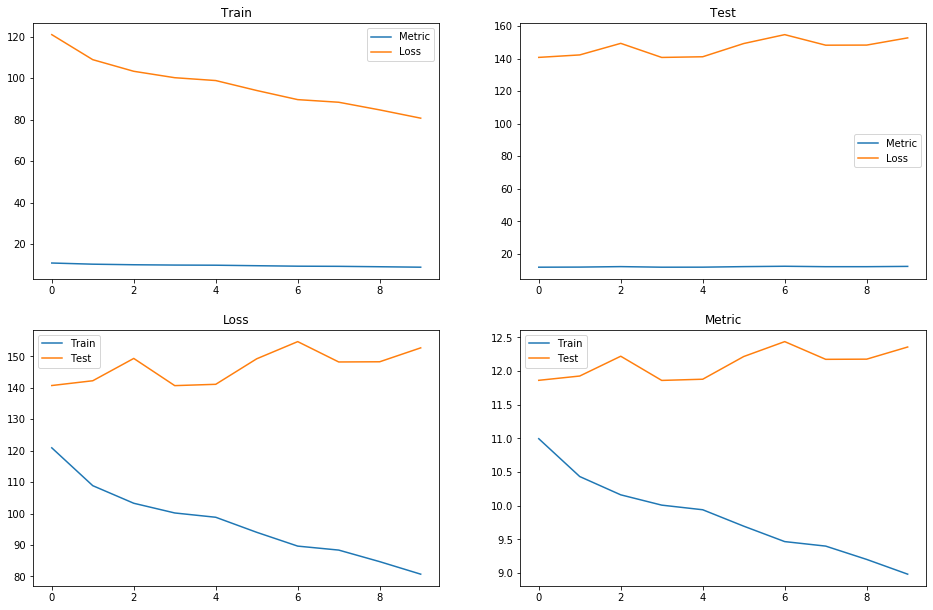

In [37]:
    fig = plt.figure()
    fig.set_size_inches(16,16)

    ax=fig.add_subplot(3,2,1)
    ax.plot(hist.history['rmse'])
    ax.plot(hist.history['mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Train')

    ax=fig.add_subplot(3,2,2)
    ax.plot(hist.history['val_rmse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Test')

    ax=fig.add_subplot(3,2,3)
    ax.plot(hist.history['mse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Loss')

    ax=fig.add_subplot(3,2,4)
    ax.plot(hist.history['rmse'])
    ax.plot(hist.history['val_rmse'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Metric')